<a href="https://colab.research.google.com/github/joanna-9/CodeAlpha/blob/main/AB_TestingandRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

In [7]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [8]:
df.shape

(294478, 5)

In [9]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

In [10]:
# The proportion of users converted

df['converted'].value_counts()[1] / (df['converted'].value_counts()[0] + df['converted'].value_counts()[1])

0.11965919355605512

In [11]:
# The number of times the `new_page` and `treatment` don't line up.

df.query("group == 'treatment' and landing_page != 'new_page'").count()[0] + \
df.query("group != 'treatment' and landing_page == 'new_page'").count()[0]

3893

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [13]:
# Regroup with new variables

df.drop(df.query("group == 'treatment' and landing_page != 'new_page'").index, inplace = True)
df.drop(df.query("group != 'treatment' and landing_page == 'new_page'").index, inplace = True)
df2 = df
df2.shape

(290585, 5)

In [14]:
# Double Check all of the correct rows were removed - this should be 0

df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [15]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

In [16]:
# Find out a duplicated

df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [17]:
# The row information for the duplicated

duplicate = df2[df2['user_id'].duplicated()]

In [18]:
# Remove the duplicated

df2.drop(duplicate.index, inplace = True)

In [19]:
df2.nunique()

user_id         290584
timestamp       290584
group                2
landing_page         2
converted            2
dtype: int64

In [20]:
# Probability

df2[df2['converted'] == 1].count()[4] / df2['converted'].count()

0.11959708724499628

In [21]:
# The probability converted in the control group

control = df2.query("group == 'control' and converted == 1").count()[4] / df2[df2['group'] == 'control'].count()[4]
control

0.1203863045004612

In [22]:
# The probability converted in the treatment group

treatment = df2.query("group == 'treatment' and converted == 1").count()[4] / df2[df2['group'] == 'treatment'].count()[4]
treatment

0.11880806551510564

In [23]:
# The probability received the new page

df2.query("landing_page == 'new_page'").count()[3] / df2['landing_page'].count()

0.5000619442226688

<a id='ab_test'></a>
### Part II - A/B Test

$$ p_{old} - p_{new} => 0$$

$$ p_{old} - p_{new} < 0 $$

In [24]:
# P_new under the null

p_new = df2.query("converted == 1").count()[4]/ df2["converted"].count()
p_new

0.11959708724499628

In [25]:
# P_old under the null

p_old = df2.query("converted == 1").count()[4]/ df2["converted"].count()
p_old

0.11959708724499628

In [26]:
n_new = df2.query('group == "treatment"').count()[0]
n_new

145310

In [27]:
n_old = df2.query('group == "control"').count()[0]
n_old

145274

In [28]:
p_dif = p_new - p_old
p_dif

0.0

In [29]:
# Store 1, 0 in new_page_converted

new_page_converted = np.random.choice([0,1], n_new, p=(p_new, 1-p_new))
new_page_converted

array([1, 0, 1, ..., 1, 1, 1])

In [30]:
# Store 1, 0 in old_page_converted

old_page_converted = np.random.choice([0,1], n_old, p=(p_old, 1-p_old))
old_page_converted

array([1, 1, 1, ..., 0, 0, 1])

In [31]:
new_page_converted.mean() - old_page_converted.mean()

-0.0006382332554765169

In [32]:
p_diffs = []
size = df2.shape[0]
for i in range(10000):
    sample = df2.sample(size, replace = True)
    new_page_converted = np.random.choice([0,1], n_new, p=(p_new, 1-p_new))
    old_page_converted = np.random.choice([0,1], n_old, p=(p_old, 1-p_old))
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())


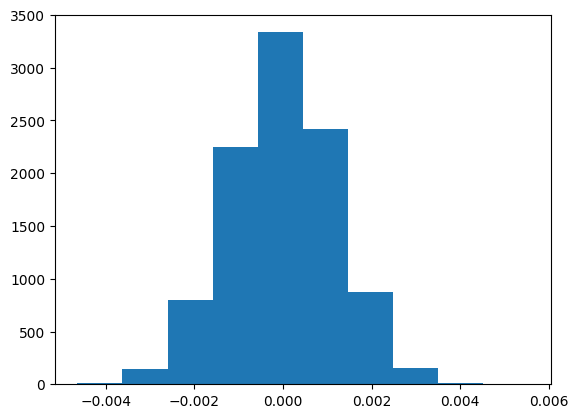

In [33]:
p_diffs = np.array(p_diffs)

plt.hist(p_diffs);

In [34]:
# The differences of actual treatment group and actual control group

obs_diffs = control - treatment
obs_diffs

0.0015782389853555567

In [35]:
# create distribution under the null hypothesis

null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

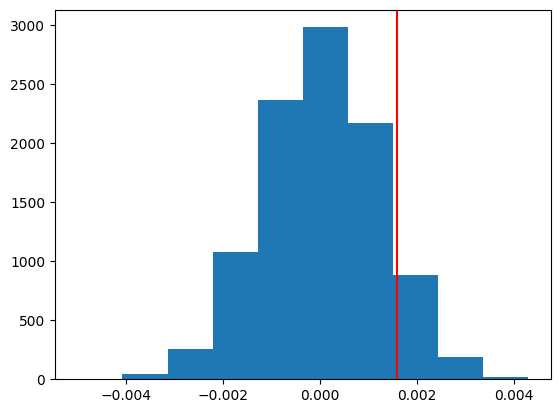

In [36]:
# plot null distribution
plt.hist(null_vals);

# plot line for observed statistic
plt.axvline(obs_diffs, c = 'red');

In [37]:
# compute p value

(null_vals > obs_diffs).mean()

0.097

In [38]:
# Apply A/B testing with statistics package

import statsmodels.api as sm

convert_old = old_page_converted.mean()
convert_new = new_page_converted.mean()

n_old = n_old
n_new = n_new

In [39]:
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new,convert_old]),np.array([n_new,n_old]), alternative = 'larger')
z_score, p_value

(-0.00027163902685445204, 0.5001083682914866)

In [40]:
from scipy.stats import norm

# Tell how significant the z-score is
norm.cdf(z_score)

0.49989163170851336

In [41]:
# Tell what the critical value at 95% confidence is

norm.ppf(1-(0.05/2))

1.959963984540054

<a id='regression'></a>
### Part III - A regression approach


In [42]:
# Logistic Regression approach

df2['intercept'] = 1

df2 = df2.join(pd.get_dummies(df2['landing_page']))
df2['ab_page'] = pd.get_dummies(df2['group']) ['treatment']

In [43]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0


In [44]:
logit = sm.Logit(df2['converted'], df2[['intercept','ab_page']])

In [45]:
# Summary: Logistic Regression model

results = logit.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 31 Mar 2024   Pseudo R-squ.:               8.077e-06
Time:                        15:37:11   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [46]:
# Modeling with countries data

countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [47]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1


In [48]:
df_new.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [49]:
df_new[['CA','UK','US']] = pd.get_dummies(df_new['country'])
df_new = df_new.drop(['CA'], axis =1)

In [50]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,1,0


In [51]:
# Summary: Logistic Regression model

df_new['intercept'] = 1

logit2 = sm.Logit(df_new['converted'], df_new[['intercept','new_page','UK','US']])
result = logit2.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 31 Mar 2024   Pseudo R-squ.:               2.323e-05
Time:                        15:37:13   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
new_page      -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [52]:
1/np.exp(-0.0149),np.exp(0.0506),np.exp(0.0408)

(1.0150115583846535, 1.0519020483004984, 1.0416437559600236)

In [53]:
# Test with more factors

df_new['UK_new_page'] = df_new['new_page']* df_new['UK']
df_new['US_new_page'] = df_new['new_page']* df_new['US']

In [54]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,UK,US,UK_new_page,US_new_page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,1,0,1,0


In [55]:
# Summary: Logistic Regression model

logit3 = sm.Logit(df_new['converted'], df_new[['intercept','new_page','UK_new_page','US_new_page','UK','US']])
result = logit3.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sun, 31 Mar 2024   Pseudo R-squ.:               3.482e-05
Time:                        15:37:14   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -2.0040      0.036    -55.008      0.000      -2.075      -1.933
new_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK_new_page     0.0783      0.057      1.378      0.168      -0.033       0.190
US_new_page     0.0469      0.054      0.872      0.383      -0.059       0.152
UK              0.0118      0.040      0.296      0.767      -0.066       0.090
US              0.0175      0.038      0.465      0.642      -0.056       0.091
===============================================================================
"""

In [56]:
1/np.exp(-0.0674),np.exp(0.0783),np.exp(0.0469),np.exp(0.0118),np.exp(0.0175)

(1.0697232819209153,
 1.0814470441230692,
 1.048017202119183,
 1.011869894648401,
 1.0176540221507617)